<a href="https://colab.research.google.com/github/Vakhranev/Heritage/blob/main/t-score%20%2B%20%D1%81%D1%82%D1%83%D0%B4%D0%B5%D0%BD%D1%82%D1%8B%3A%20%D1%8F%D1%89%D0%B8%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Загрузка данных из CSV файла
df = pd.read_csv('sorted_bigrams_unique_t_score.csv')

# Удаление повторяющихся строк
df.drop_duplicates(inplace=True)

# Сохранение изменений в файле
df.to_csv('sorted_bigrams_unique_t_score.csv', index=False)

In [ ]:
import json
import pandas as pd
from tqdm import tqdm

# Загрузка данных из файла с частотами униграмм
with open('cococo_unigram_freq_fixed.json', 'r', encoding='utf-8') as file:
    unigrams_dict = json.load(file)

# Загрузка данных из CSV файла
df = pd.read_csv('sorted_bigrams_unique_t_score.csv')

# Преобразование данных в словарь
bigrams_dict = dict(zip(df['Bigram'], df['T_Score']))

# Функция для пересчёта t-score
def calc_t_score(bigrams_dict, unigrams_dict):
    N = sum(bigrams_dict.values())
    bigram_t = {}
    max_tscore = 0
    p_bar = tqdm(desc="calculate t-score", total=len(bigrams_dict))
    for bigram, count in bigrams_dict.items():
        w1, w2 = bigram.split()
        unigram_freq_w1 = unigrams_dict.get(w1, 0)
        unigram_freq_w2 = unigrams_dict.get(w2, 0)
        if count == 0 or unigram_freq_w1 == 0 or unigram_freq_w2 == 0:
            # Пропускаем биграммы с нулевым количеством или нулевой частотой униграмм
            continue
        E_xy = (unigram_freq_w1 + unigram_freq_w2) / N
        t_score = abs((count - E_xy) / (count ** 0.5)) # Берем абсолютное значение разницы
        bigram_t[bigram] = t_score
        if t_score > max_tscore:
            max_tscore = t_score
        p_bar.update()
    bigram_t = {bigram: bigram_t[bigram] / max_tscore for bigram in sorted(bigram_t, key=bigram_t.get, reverse=True)} # sort and normalize
    return bigram_t

# Применение функции к данным
result = calc_t_score(bigrams_dict, unigrams_dict)

# Преобразование результата в DataFrame
result_df = pd.DataFrame({'Bigram': list(result.keys()), 'T_Score': list(result.values())})

# Сохранение результата в файл
result_df.to_csv('sorted_bigrams_unique_t_score_normalized.csv', index=False)

calculate t-score:  88%|████████▊ | 3651/4160 [00:00<00:00, 222746.90it/s]


Отсутствующие файлы в LEVEL 2: EC12_B1_2114_tagged_CORRECTED, EC12_B1_2421_tagged_CORRECTED, EC12_B1_6143_tagged_CORRECTED, EC12_B1_6378_tagged_CORRECTED, 24
Отсутствующие файлы в LEVEL 3: EC12_B1_2495_tagged_CORRECTED, EC12_B1_2882_tagged_CORRECTED, EC12_B1_2967_tagged_CORRECTED, EC12_B1_3089_tagged_CORRECTED, EC12_B1_3300_tagged_CORRECTED, EC12_B1_3544_tagged_CORRECTED, EC12_B1_3769_tagged_CORRECTED, EC12_B1_4129_tagged_CORRECTED, EC12_B1_4757_tagged_CORRECTED, EC12_B1_4803_tagged_CORRECTED, EC12_B1_5000_tagged_CORRECTED, EC12_B1_5791_tagged_CORRECTED, EC12_B1_7455_tagged_CORRECTED, EC12_B1_9529_tagged_CORRECTED, EC12_B2_1189_tagged_ST_CORRECTED, EC12_B2_2420_tagged_ST_CORRECTED, EC12_B2_3893_tagged_ST_CORRECTED, EC12_B2_4268_tagged_ST_CORRECTED, EC12_B2_5926_tagged_ST_CORRECTED, EC12-B1_0662_tagged_CORRECTED, EC12-B1_0913_tagged_CORRECTED, EC12-B1_6912_tagged_CORRECTED, EC12-B1_8350_tagged_CORRECTED, EC12-B1_8772_tagged_CORRECTED, EC12-B1_9158_tagged_CORRECTED, EC12-B1_9855_tagged_C

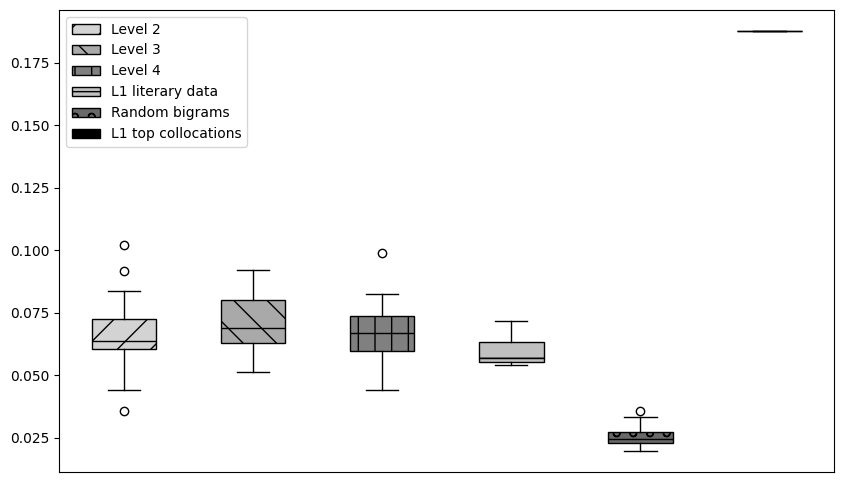

LEVEL 2:
  Min Value: 0.035552390202333944
  Lower Quartile (Q1): 0.06037078583609861
  Upper Quartile (Q3): 0.07236162388077855
  Max Value: 0.10208876448191229
  Mean Value: 0.06624593819988749

LEVEL 3:
  Min Value: 0.0512594574891066
  Lower Quartile (Q1): 0.06286311159479757
  Upper Quartile (Q3): 0.079955613170433
  Max Value: 0.09215089804019501
  Mean Value: 0.07079753503535444

LEVEL 4:
  Min Value: 0.04418639001655464
  Lower Quartile (Q1): 0.05966366839034265
  Upper Quartile (Q3): 0.07381815584840735
  Max Value: 0.09902263327511442
  Mean Value: 0.06638860638029329

lib_texts:
  Min Value: 0.05420565433568166
  Lower Quartile (Q1): 0.05535886884387787
  Upper Quartile (Q3): 0.06327895560039593
  Max Value: 0.0717036096442014
  Mean Value: 0.05956457668182604

lib_random_texts:
  Min Value: 0.01969891665073924
  Lower Quartile (Q1): 0.023095606802518695
  Upper Quartile (Q3): 0.027248526712223865
  Max Value: 0.035743795671482066
  Mean Value: 0.025385883951685846

best t-s

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Функция для подсчета количества токенов в тексте
def count_tokens(text):
    return len(text.split())

# Чтение файла sorted_bigrams_unique_t_score_normalized.csv
df = pd.read_csv('sorted_bigrams_unique_t_score_normalized.csv')

# Чтение файла america_texts.json
mmr_data = {}
mmr_token_counts = {}
with open('america_texts.json', 'r') as file:
    mrr_texts_data = json.load(file)
    for text_name, text_info in mrr_texts_data.items():
        mmr_rank_unique = text_info.get('mmr_t_score_unique', 0)
        text_content = text_info.get('text', '')
        mmr_data[text_name] = mmr_rank_unique
        mmr_token_counts[text_name] = count_tokens(text_content)

# Чтение файла files_by_levels.txt
files_by_levels = {'LEVEL 2': [], 'LEVEL 3': [], 'LEVEL 4': []}
with open('files_by_levels.txt', 'r') as file:
    current_level = None
    for line in file:
        line = line.strip()
        if line.startswith('LEVEL'):
            current_level = line
        elif line:
            files_by_levels[current_level].append(line)

# Проверка наличия файлов в mmr_data
missing_files = {'LEVEL 2': [], 'LEVEL 3': [], 'LEVEL 4': []}
for level, files in files_by_levels.items():
    for file in files:
        if file not in mmr_data:
            missing_files[level].append(file)

# Печать отсутствующих файлов
for level, files in missing_files.items():
    if files:
        print(f"Отсутствующие файлы в {level}: {', '.join(files)}")

# Чтение файла lib_texts.json
lib_texts = {}
lib_token_counts = {}
with open('lib_texts.json', 'r') as file:
    lib_texts_data = json.load(file)
    for text_name, text_info in lib_texts_data.items():
        mmr_rank_unique = text_info.get('mmr_t_score_unique', 0)
        text_content = text_info.get('text', '')
        lib_texts[text_name] = mmr_rank_unique
        lib_token_counts[text_name] = count_tokens(text_content)

# Чтение файла lib_random_texts.json
lib_random_texts = {}
lib_random_collocations = 0
with open('lib_random_texts.json', 'r') as file:
    lib_random_texts_data = json.load(file)
    for text_name, text_info in lib_random_texts_data.items():
        temporal_text_name = text_name + "_"
        for text_type, text_other in text_info.items():
            if text_type == 'random_texts':
                for text_number, text_else in text_other.items():
                    temporal_text_name += text_number
                    mmr_rank_unique = text_else.get('mmr_t_score_unique')
                    text_content = text_else.get('text', '')
                    lib_random_texts[temporal_text_name] = mmr_rank_unique
                    lib_token_counts[temporal_text_name] = count_tokens(text_content)
                    temporal_text_name = text_name + "_"

# Подсчет коллокаций по количеству элементов в bigrams_freq
# Перебор каждого текста в JSON
for text_name, text_info in lib_random_texts_data.items():
    for text_type, text_other in text_info.items():
        if text_type == 'random_texts':
            for text_number, text_else in text_other.items():
                temporal_text_name = text_name + "_" + text_number
                bigrams_freq = text_else.get('bigrams_freq', {})
                lib_random_collocations += len(bigrams_freq)
                lib_token_counts[temporal_text_name] = count_tokens(text_else.get('text', ''))

# Построение диаграммы
plt.figure(figsize=(10, 6))

# Сбор данных для ящиков с усами из files_by_levels
data_to_plot = []
labels_to_plot = []
for level, files in files_by_levels.items():
    data = []
    for file in files:
        if file in mmr_data:
            data.append(mmr_data[file])
    data_to_plot.append(data)
    labels_to_plot.append(level)

# Сбор данных для ящиков с усами из lib_texts
data_to_plot.append(list(lib_texts.values()))
labels_to_plot.append('lib_texts')

# Сбор данных для ящиков с усами из lib_random_texts
data_to_plot.append(list(lib_random_texts.values()))
labels_to_plot.append('lib_random_texts')

# Рассчитываем средний t-score для файла sorted_bigrams_unique_t_score_normalized.csv
average_t_score = df['T_Score'].mean()

# Добавляем средний t-score в данные для построения диаграммы
data_to_plot.append([average_t_score])
labels_to_plot.append('best t-scores')

# Обновление словаря штриховок для новой легенды
patterns = {
    'LEVEL 2': '/',
    'LEVEL 3': '\\',
    'LEVEL 4': '|',
    'lib_texts': '-',
    'lib_random_texts': 'o',
    'best t-scores': '+'
}

# Построение ящиков с усами
bp = plt.boxplot(data_to_plot, patch_artist=True)

# Установка палитры Grayscale для ящиков
colors = ['lightgrey', 'darkgrey', 'grey', 'silver', 'dimgray', 'black']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Установка штриховок для ящиков
for patch, label in zip(bp['boxes'], labels_to_plot):
    patch.set_hatch(patterns[label])

# Установка черного цвета для медианной линии
for median in bp['medians']:
    median.set_color('black')

# Новые метки для легенды
new_labels = {
    'LEVEL 2': "Level 2",
    'LEVEL 3': "Level 3",
    'LEVEL 4': "Level 4",
    'lib_texts': "L1 literary data",
    'lib_random_texts': "Random bigrams",
    'best t-scores': "L1 top collocations"
}

# Добавление легенды
legend_handles = [plt.Rectangle((0,0),1,1, hatch=patterns[label], edgecolor='black', facecolor=color) for label, color in zip(labels_to_plot, colors)]
plt.legend(legend_handles, [new_labels[label] for label in labels_to_plot])

# Удаление подписей с оси x
plt.xticks([])

# Показать диаграмму
plt.show()

# Вывод нижней и верхней границ ящиков (2 и 3 квартиль), среднего значения и общих границ для каждого уровня и lib_texts
for level, data in zip(labels_to_plot, data_to_plot):
    if data:  # проверка, чтобы не было пустых данных
        min_value = np.min(data)
        lower_quartile = np.percentile(data, 25)
        upper_quartile = np.percentile(data, 75)
        max_value = np.max(data)
        mean_value = np.mean(data)
        print(f"{level}:")
        print(f"  Min Value: {min_value}")
        print(f"  Lower Quartile (Q1): {lower_quartile}")
        print(f"  Upper Quartile (Q3): {upper_quartile}")
        print(f"  Max Value: {max_value}")
        print(f"  Mean Value: {mean_value}\n")
    else:
        print(f"{level}: No data available\n")

# Вывод количества токенов для каждого уровня и lib_texts
total_tokens_by_level = {}
for level, files in files_by_levels.items():
    total_tokens = sum(mmr_token_counts[file] for file in files if file in mmr_token_counts)
    total_tokens_by_level[level] = total_tokens
    print(f"{level} Total Tokens: {total_tokens}")

lib_texts_total_tokens = sum(lib_token_counts.values())
total_tokens_by_level['lib_texts'] = lib_texts_total_tokens
print(f"lib_texts Total Tokens: {lib_texts_total_tokens}")

# Вывод общего количества токенов
overall_total_tokens = sum(total_tokens_by_level.values())
print(f"Overall Total Tokens: {overall_total_tokens}")

# Подсчет количества коллокаций для топовых и рандомных текстов
top_collocations_count = df.shape[0]
random_collocations_count = len(lib_random_texts)

print(f"Top Collocations Count: {top_collocations_count}")
print(f"Random Collocations Count: {random_collocations_count}")

In [ ]:
# Подсчёт пограничных значений без учёта выбросов для каждого уровня
for i, data in enumerate(data_to_plot[:3]):
    q1 = pd.Series(data).quantile(0.25)
    q3 = pd.Series(data).quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = [value for value in data if value < lower_bound or value > upper_bound]
    non_outliers = [value for value in data if value >= lower_bound and value <= upper_bound]
    print(f"LEVEL {i+2} (without outliers):")
    print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    print(f"Outliers: {outliers}")
    print(f"Non-outliers: {non_outliers}\n")

LEVEL 2 (without outliers):
Lower Bound: 0.029406647520939827, Upper Bound: 0.09813460969668178
Outliers: [0.10208876448191229]
Non-outliers: [0.04416102778971158, 0.09188216631266351, 0.05993666281461927, 0.06197428872007017, 0.08365550670186747, 0.06335419860197582, 0.06672125641061953, 0.05581244070873723, 0.07118307368967633, 0.06445105686208505, 0.040643357114606246, 0.06051549350992506, 0.04860735260095526, 0.07370827947509422, 0.06089672418274194, 0.07708493896033747, 0.051164923492866776, 0.035552390202333944, 0.07191273868267332, 0.05328121122116054, 0.08786869405286014, 0.06713535279066533, 0.06172747960717345]

LEVEL 3 (without outliers):
Lower Bound: 0.037224359231344435, Upper Bound: 0.10559436553388613
Outliers: []
Non-outliers: [0.06472554178654498, 0.0848536793951305, 0.07015206094280078, 0.0512594574891066, 0.09215089804019501, 0.057275821019555334, 0.07832292442886717, 0.06763989718063515]

LEVEL 4 (without outliers):
Lower Bound: 0.040204644455687416, Upper Bound: 0.

In [ ]:
# Перебор каждого текста в JSON
for text_name, text_info in lib_random_texts_data.items():
    # Вывод информации о каждом тексте
    print(f"Text Name: {text_name}")
    print(f"Text Info: {text_info}")

Text Name: Исключительная личность
Text Info: {'original_text': 'Исключительная личность\nГенерал аншеф князь Николай Болконский "с того времени, как при императоре Павле был сослан в деревню, жил безвыездно в своих Лысых Горах с дочерью, княжною Марей и при ней компаньонкой, m-lle Bourienne". Лысая гора в нарицательном смысле обозначает гору или высокий холм с плоской, как бы срезанной вершиной, на которой деревья не растут, что по виду напоминает лысину. По народным поверьям лысая гора служит прибежищем нечистой силы, местом шабашей, черных ритуалов, связанных с колдовством. Конечно, было бы опрометчивым утверждать, что каждая точка на карте с таким названием однозначно притягивает нечисть, но просто так, без каких-либо оснований такое название вряд ли дается, между названием и сутью чаще всего имеется связь. Все это не может не наводить на размышления о каких-то сверхспособностях князя, тем более что, судя по множественному числу, в этой местности была даже не одна, а несколько таки